<a href="https://colab.research.google.com/github/mella30/Deep-Learning-with-Tensorflow-2/blob/main/Course3-Probabilistic_Deep_Learning_with_Tensorflow2/week2_probabilistic_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)

TF version: 2.6.0
TFP version: 0.13.0


# Probabilistic layers and Bayesian neural networks

## Coding tutorials
#### [1. The DistributionLambda layer](#coding_tutorial_1)
#### [2. Probabilistic layers](#coding_tutorial_2)
#### [3. The DenseVariational layer](#coding_tutorial_3)
#### [4. Reparameterization layers](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## The `DistributionLambda` layer

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#### Create a probabilistic model using the `DistributionLambda` layer

Create a model whose first layer represents:

$$
y = \text{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.
$$

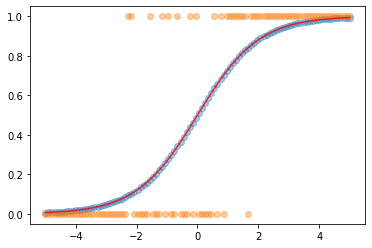

In [ ]:
# Create a deterministic and a probabilistic sigmoid model

model_deterministic = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
          kernel_initializer=tf.constant_initializer(1),
          bias_initializer=tf.constant_initializer(0)),
])

model_probabilistic = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
          kernel_initializer=tf.constant_initializer(1),
          bias_initializer=tf.constant_initializer(0)),
    tfpl.DistributionLambda(lambda t : tfd.Bernoulli(probs=t),
                            convert_to_tensor_fn=tfd.Distribution.sample)  # can also be mean, ...
])

# Plot the function
x_plot = np.linspace(-5, 5, 100)
plt.scatter(x_plot, model_deterministic.predict(x_plot), alpha=0.4)
plt.scatter(x_plot, model_probabilistic.predict(x_plot), alpha=0.4)
plt.plot(x_plot, 1/(1 + np.exp(-x_plot)), color='r', alpha=0.8)
plt.show()


In [ ]:
# Create a constant input for this model

x = np.array([[0]])

In [ ]:
# Explore the feedforward object...

y_deterministic = model_deterministic(x)
y_deterministic

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5]], dtype=float32)>

In [ ]:
y_probabilistic = model_probabilistic(x)
y_probabilistic

<tfp.distributions.Bernoulli 'sequential_1_distribution_lambda_Bernoulli' batch_shape=[1, 1] event_shape=[] dtype=int32>

In [ ]:
# ... and its behaviour under repeated calls

for _ in range(5):
  print(model_deterministic.predict(x))
  print(model_probabilistic.predict(x))
  print("\n")

[[0.5]]
[[0]]


[[0.5]]
[[1]]


[[0.5]]
[[1]]


[[0.5]]
[[1]]


[[0.5]]
[[0]]




#### Use the forward model to create probabilistic training data

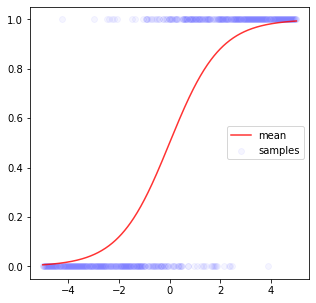

In [ ]:
# Use the model to create 500 training points

x_train = np.linspace(-5, 5, 500)[:, np.newaxis]
y_train = model_probabilistic.predict(x_train)

# Plot the data and the mean of the distribution
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x_train, y_train, alpha=0.04, color='blue', label='samples')
ax.plot(x_train, model_probabilistic(x_train).mean().numpy().flatten(), 
        color='red', alpha=0.8, label='mean')
ax.legend()
plt.show()

#### Create a new probabilistic model with the wrong weights

In [ ]:
# Create a new version of the model, with the wrong weights

model_untrained = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
          kernel_initializer=tf.constant_initializer(2), # change the weight initializer
          bias_initializer=tf.constant_initializer(2)),
    tfpl.DistributionLambda(lambda t : tfd.Bernoulli(probs=t),
                            convert_to_tensor_fn=tfd.Distribution.sample)  # can also be mean, ...
])

#### Train the new model with the negative loglikelihood

In [ ]:
# Define negative loglikelihood, which we will use for training

def nll(y_true, y_pred):
  # .log_prob() take the log probability of the true training data (which is a distribution object)
  return -y_pred.log_prob(y_true)

In [ ]:
# Compile untrained model

model_untrained.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))

In [ ]:
# Train model, record weights after each epoch

epochs = [0]
training_weights = [model_untrained.weights[0].numpy()[0, 0]]
training_bias = [model_untrained.weights[1].numpy()[0]]
for epoch in range(100):
    model_untrained.fit(x=x_train, y=y_train, epochs=1, verbose=False)
    epochs.append(epoch)
    training_weights.append(model_untrained.weights[0].numpy()[0, 0])
    training_bias.append(model_untrained.weights[1].numpy()[0])

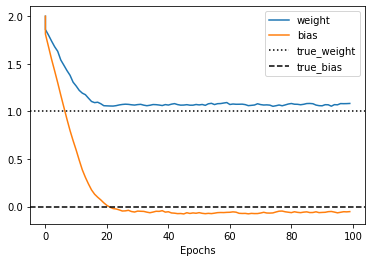

In [ ]:
# Plot the model weights as they train, converging to the correct values

plt.plot(epochs, training_weights, label='weight')
plt.plot(epochs, training_bias, label='bias')
plt.axhline(y=1, label='true_weight', color='k', linestyle=':')
plt.axhline(y=0, label='true_bias', color='k', linestyle='--')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# epistemic uncertainty prevents the weights to exactly fit the original parameter values
# (data are not perfectly representing the original model)

***
<a id="coding_tutorial_2"></a>
## Probabilistic layers

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#### Create data

The data you'll be working with is artifically created from the following equation:
$$ y_i = x_i + \frac{3}{10}\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

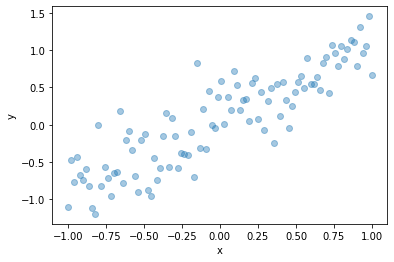

In [ ]:
# Create and plot 100 points of training data

x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Deterministic linear regression with MSE loss

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


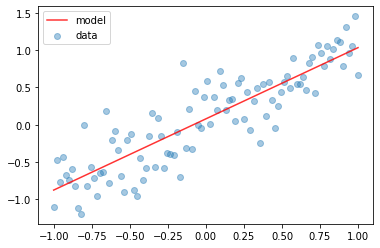

In [ ]:
# Create and train deterministic linear model using mean squared error loss

# Create linear regression via Sequential model
model_deterministic = Sequential([
    Dense(units=1, input_shape=(1,))
])
model_deterministic.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model_deterministic.summary()
model_deterministic.fit(x_train, y_train, epochs=200, verbose=False)

# Plot the data and model
plt.scatter(x_train, y_train, alpha=0.4, label='data')
plt.plot(x_train, model_deterministic.predict(x_train), color='red', alpha=0.8, label='model')
plt.legend()
plt.show()

In [ ]:
# Examine the model predictions

x = np.array([[0]])
y_deterministic = model_deterministic(x)
y_deterministic

# does not capture the aleatoric uncertainty

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.07848563]], dtype=float32)>

#### Probabilistic linear regression with both user-defined and learned variance

In [ ]:
# Create probabilistic regression with normal distribution as final layer
# take the output of the Dense layer to parameterize the mean of the normal distribution

event_shape=1
model_probabilistic = Sequential([
    Dense(units=tfpl.IndependentNormal.params_size(event_shape=1), input_shape=(1,)),
    tfpl.IndependentNormal(event_shape=event_shape)
])

model_probabilistic.summary()  # output is a distribution

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 2)                 4         
_________________________________________________________________
independent_normal (Independ multiple                  0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train model using the negative loglikelihood

def nll(y_true, y_pred):
  return -y_pred.log_prob(y_true)

model_probabilistic.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model_probabilistic.fit(x_train, y_train, epochs=200, verbose=False)

In [ ]:
# Examine the distribution created as a feedforward value

y_probabilistic = model_probabilistic(x)
y_probabilistic

<tfp.distributions.Independent 'sequential_6_independent_normal_IndependentNormal_Independentsequential_6_independent_normal_IndependentNormal_Normal' batch_shape=[1] event_shape=[1] dtype=float32>

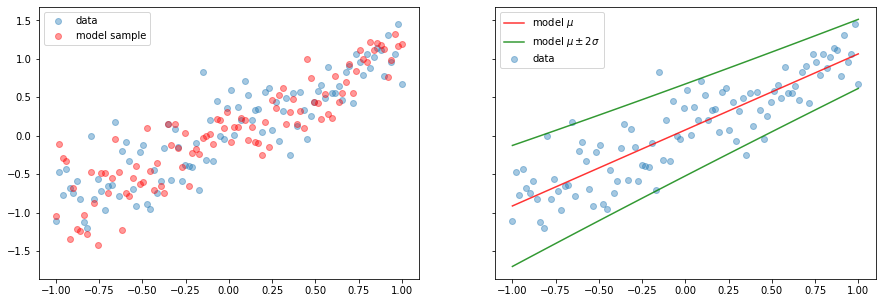

In [ ]:
# Plot the data and a sample from the model

y_model = model_probabilistic(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()


#### Probabilistic linear regression with nonlinear learned mean & variance

Let's change the data to being nonlinear:
$$ y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

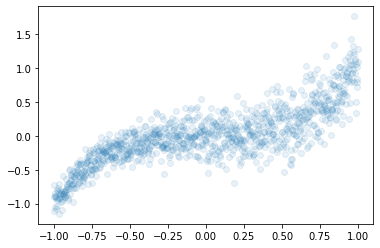

In [ ]:
# Create and plot 10000 data points

x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.1)
plt.show()

In [ ]:
# Create probabilistic regression: normal distribution with fixed variance

model = Sequential([
    Dense(input_shape=(1,), units=8, activation='sigmoid'),
    Dense(tfpl.IndependentNormal.params_size(event_shape=1)),
    tfpl.IndependentNormal(event_shape=1)
])
model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 8)                 16        
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 18        
_________________________________________________________________
independent_normal_1 (Indepe multiple                  0         
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train model

model.fit(x_train, y_train, epochs=200, verbose=False)
model.evaluate(x_train, y_train)

32/32 [==============================] - 0s 2ms/step - loss: -0.1711


-0.17113591730594635

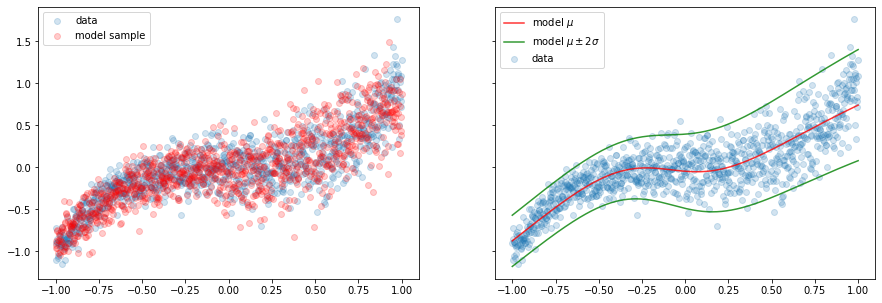

In [ ]:
# Plot the data and a sample from the model

y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.2, label='data')
ax1.scatter(x_train, y_sample, alpha=0.2, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.2, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

***
<a id="coding_tutorial_3"></a>
## The `DenseVariational` layer

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#### Create linear data with Gaussian noise

The data you'll be working with is the same as you used before:
$$ y_i = x_i + \frac{3}{10}\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed. We'll be running a Bayesian linear regression on this data.

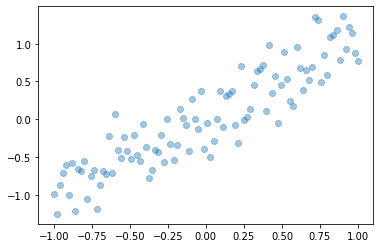

In [12]:
# Use the same data as before -- create and plot 100 data points

x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.4)
plt.show()

#### Create the prior and posterior distribution for model weights

In [16]:
# Define the prior weight distribution -- all N(0, 1) -- and not trainable

def prior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size  # total number of paramters in the layer
  prior_model = Sequential([
                            # this model does not have any trainable parameters (hard-coded zeros)
                            # (a trainable prior would generally be possible)
                            tfpl.DistributionLambda(
                                lambda t : tfd.MultivariateNormalDiag(loc=tf.zeros(n),
                                                                scale_diag=tf.ones(n)))                            
  ])
  # returns a distribution
  return prior_model  

In [17]:
# Define variational posterior weight distribution -- multivariate Gaussian

def posterior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size  # total number of paramters in the layer
  posterior_model = Sequential([
                                # this model needs trainable paramters since it should be learned from the data
                                # use a variable layer to learn the parameters of the multivariate normal distribution
                                tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),  # multivariate gaussian with full covariance matrix
                                tfpl.MultivariateNormalTriL(n)
  ])
  return posterior_model

#### Aside: analytical posterior

In this tutorial, we're using a variational posterior because, in most settings, it's not possible to derive an analytical one. However, in this simple setting, it is possible. Specifically, running a Bayesian linear regression on $x_i$ and $y_i$ with $i=1, \ldots, n$ and a unit Gaussian prior on both $\alpha$ and $\beta$:

$$
y_i = \alpha + \beta x_i + \epsilon_i, \quad 
\epsilon_i \sim N(0, \sigma^2), \quad 
\alpha \sim N(0, 1), \quad 
\beta \sim N(0, 1)
$$

gives a multivariate Gaussian posterior on $\alpha$ and $\beta$:

$$
\begin{pmatrix}
\alpha \\
\beta
\end{pmatrix}
\sim
N(\mathbf{\mu}, \mathbf{\Sigma})
$$
where
$$ 
\mathbf{\mu}
= 
\mathbf{\Sigma} 
\begin{pmatrix}
\hat{n} \bar{y} \\
\hat{n} \overline{xy}
\end{pmatrix},
\quad
\mathbf{\Sigma} = 
\frac{1}{(\hat{n} + 1)(\hat{n} \overline{x^2} + 1) - \hat{n}^2 \bar{x}^2}
\begin{pmatrix}
\hat{n} \overline{x^2} + 1 & -\hat{n} \bar{x} \\
-\hat{n} \bar{x} & \hat{n} + 1
\end{pmatrix}.
$$

In the above, $\hat{n} = \frac{n}{\sigma^2}$ and $\bar{t} = \frac{1}{n}\sum_{i=1}^n t_i$ for any $t$. In general, however, it's not possible to determine the analytical form for the posterior. For example, in models with a hidden layer with nonlinear activation function, the analytical posterior cannot be determined in general, and variational methods as below are useful.

#### Create the model with `DenseVariational` layers

In [20]:
# Create linear regression model with weight uncertainty: weights are
# distributed according to posterior (and, indirectly, prior) distribution

model = Sequential([
                    tfpl.DenseVariational(input_shape=(1,), 
                                          units=1,
                                          make_prior_fn=prior,
                                          make_posterior_fn=posterior,
                                          kl_weight=1/x_train.shape[0],
                                          kl_use_exact=True)  # tfp has stored the analytically calculated KL divergence between many common distributions
])

model.compile(loss=MeanSquaredError(),
              optimizer=RMSprop(learning_rate=0.005))
model.summary()
# usual linear regression has only 2 parameters: the slope and the y-intercept
# here, the weights have distributions, that means:
# - the mean and the variance of the slope
# - the mean and the variance of the y-intercept
# - the covariance between them

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_3 (DenseVa (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


#### Train model and inspect

In [21]:
# Fit the model, just like a deterministic linear regression

model.fit(x_train, y_train, epochs=500, verbose=False)

In [22]:
# Check out the parameters of the prior and posterior distribution

dummy_input = np.array([[0]])
model_prior = model.layers[0]._prior(dummy_input)
model_posterior = model.layers[0]._posterior(dummy_input)
# the variables of the prior are set to unit gaussians and are not trainable
print('prior mean:           ', model_prior.mean().numpy())
print('prior variance:       ', model_prior.variance().numpy())
# learned mean for the slope and y-intercept (were 1. and 0.)
print('posterior mean:       ', model_posterior.mean().numpy())
# learned variance for the slope and the y-intercept (uncertainty) are on the diagnoal of the covariance matrix
print('posterior covariance: ', model_posterior.covariance().numpy()[0])
# learned covariance between slope and y-intercept are on the off-diagonal (are equal)
print('                      ', model_posterior.covariance().numpy()[1])

prior mean:            [0. 0.]
prior variance:        [1. 1.]
posterior mean:        [1.031903   0.02067014]
posterior covariance:  [0.01871124 0.00036539]
                       [0.00036539 0.00582248]


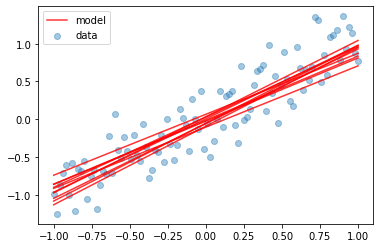

In [23]:
# Plot an ensemble of linear regressions, with weights sampled from the posterior distribution
# this shows the epistemic uncertainty: we don't actually know which model produced the data

plt.scatter(x_train, y_train, alpha=0.4, label='data')
for _ in range(10):
    y_model = model(x_train)
    if _ == 0:
        plt.plot(x_train, y_model, color='red', alpha=0.8, label='model')
    else:
        plt.plot(x_train, y_model, color='red', alpha=0.8)        
plt.legend()
plt.show()

#### Explore the effect of sample size

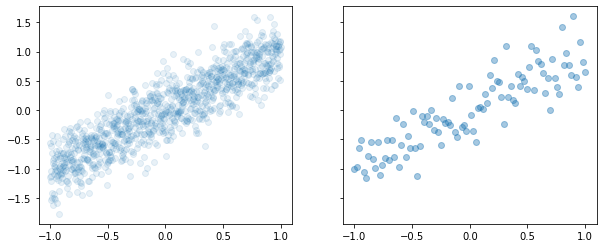

In [24]:
# epistemic uncertainty can be explained away with more data

# Create two datasets, one with 1000 points, another with 100

x_train_1000 = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train_1000 = x_train_1000 + 0.3*np.random.randn(1000)[:, np.newaxis]

x_train_100 = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train_100 = x_train_100 + 0.3*np.random.randn(100)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
ax1.scatter(x_train_1000, y_train_1000, alpha=0.1)
ax2.scatter(x_train_100, y_train_100, alpha=0.4)
plt.show()

In [25]:
# Train a model on each dataset

model_1000 = Sequential([tfpl.DenseVariational(input_shape=(1,), 
                                               units=1,
                                               make_prior_fn=prior, 
                                               make_posterior_fn=posterior,
                                               kl_weight=1/1000)])

model_100 = Sequential([tfpl.DenseVariational(input_shape=(1,), 
                                              units=1,
                                              make_prior_fn=prior, 
                                              make_posterior_fn=posterior,
                                              kl_weight=1/100)])

model_1000.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model_100.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))

model_1000.fit(x_train_1000, y_train_1000, epochs=50, verbose=False)
model_100.fit(x_train_100, y_train_100, epochs=500, verbose=False)

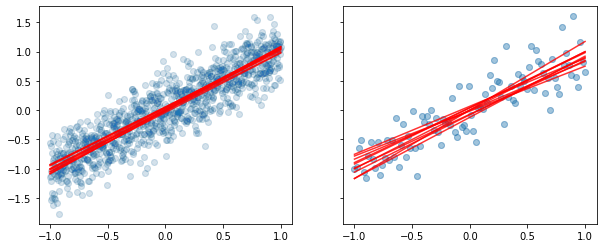

In [26]:
# Plot an ensemble of linear regressions from each model

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for _ in range(10):
    y_model_1000 = model_1000(x_train_1000)
    ax1.scatter(x_train_1000, y_train_1000, color='C0', alpha=0.02)
    ax1.plot(x_train_1000, y_model_1000, color='red', alpha=0.8)
    y_model_100 = model_100(x_train_100)
    ax2.scatter(x_train_100, y_train_100, color='C0', alpha=0.05)
    ax2.plot(x_train_100, y_model_100, color='red', alpha=0.8)
plt.show()

# the variance (= uncertainty) in the outputs of the right model (with fewer samples) 
# is higher as in the left model (with more samples)

#### Put it all together: nonlinear probabilistic regression with weight uncertainty

Let's change the data to being nonlinear:
$$ y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

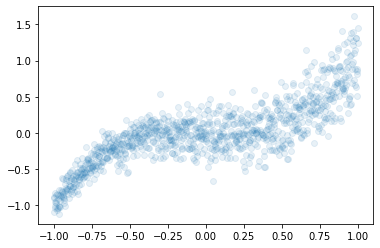

In [27]:
# Create and plot 1000 data points

x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.1)
plt.show()

In [28]:
# Create probabilistic regression with one hidden layer, weight uncertainty

model = Sequential([
    # epistemic uncertainty modelling
    tfpl.DenseVariational(units=8,
                          input_shape=(1,),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0],
                          activation='sigmoid'),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0]),
    # aleatoric uncertainty modelling
    tfpl.IndependentNormal(1)
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_6 (DenseVa (None, 8)                 152       
_________________________________________________________________
dense_variational_7 (DenseVa (None, 2)                 189       
_________________________________________________________________
independent_normal (Independ multiple                  0         
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Train the model

model.fit(x_train, y_train, epochs=1000, verbose=False)
model.evaluate(x_train, y_train)

32/32 [==============================] - 0s 1ms/step - loss: -0.0523


-0.052341680973768234

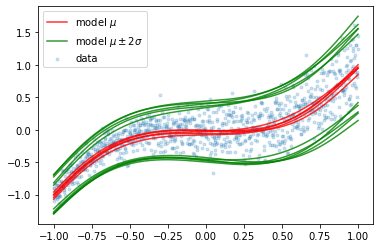

In [31]:
# Plot an ensemble of trained probabilistic regressions

plt.scatter(x_train, y_train, marker='.', alpha=0.2, label='data')
for _ in range(5):
    y_model = model(x_train)
    y_hat = y_model.mean()
    y_hat_m2sd = y_hat - 2 * y_model.stddev()
    y_hat_p2sd = y_hat + 2 * y_model.stddev()
    if _ == 0:
        plt.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
    else:
        plt.plot(x_train, y_hat, color='red', alpha=0.8)
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8)
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)        
plt.legend()
plt.show()

# epistemic uncertainty: possible models vary
# aleatoric uncertainty: points don't lie exactly on the lines

***
<a id="coding_tutorial_4"></a>
## Reparameterization layers

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop
import os
import numpy as np
import matplotlib.pyplot as plt

# in the newer tfp versions, there are implementations of the convolutional variational layers:
# https://www.tensorflow.org/probability/api_docs/python/tfp/layers/conv_variational

#### Load in the HAR dataset

You'll be working with the [Human Activity Recognition (HAR) Using Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. It consists of the readings from an accelerometer (which measures acceleration) carried by a human doing different activities. The six activities are walking horizontally, walking upstairs, walking downstairs, sitting, standing and laying down. The accelerometer is inside a smartphone, and, every 0.02 seconds (50 times per second), it takes six readings: linear and gyroscopic acceleration in the x, y and z directions. See [this link](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) for details and download. If you use it in your own research, please cite the following paper:

- Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013. 

The goal is to use the accelerometer data to predict the activity.

#### Import the data

The dataset required for this coding tutorial can be downloaded from the following link:

https://drive.google.com/file/d/1U_O3bhvuSAzQDKHGWcBIAO80iV9FVmDo/view?usp=sharing

You should store this file in Drive for use in this Colab notebook.

In [33]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [46]:
# Load the HAR dataset and create some data processing functions

# Function to load the data from file
def load_HAR_data():
    data_dir = '/content/gdrive/MyDrive/HAR.zip (Unzipped Files)/HAR'
    x_train = np.load(os.path.join(data_dir, 'x_train.npy'))[..., :6]
    y_train = np.load(os.path.join(data_dir, 'y_train.npy')) - 1
    x_test  = np.load(os.path.join(data_dir, 'x_test.npy'))[..., :6]
    y_test  = np.load(os.path.join(data_dir, 'y_test.npy')) - 1
    return (x_train, y_train), (x_test, y_test)

# Dictionary containing the labels and the associated activities
label_to_activity = {0: 'walking horizontally', 1: 'walking upstairs', 2: 'walking downstairs',
                     3: 'sitting', 4: 'standing', 5: 'laying'}

# Function to change integer labels to one-hot labels
def integer_to_onehot(data_integer):
    data_onehot = np.zeros(shape=(data_integer.shape[0], data_integer.max()+1))
    for row in range(data_integer.shape[0]):
        integer = int(data_integer[row])
        data_onehot[row, integer] = 1
    return data_onehot

# Load the data
(x_train, y_train), (x_test, y_test) = load_HAR_data()
y_train_oh = integer_to_onehot(y_train)
y_test_oh = integer_to_onehot(y_test)

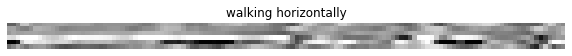

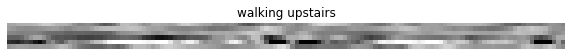

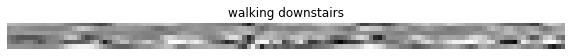

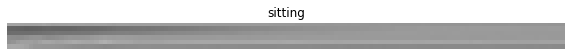

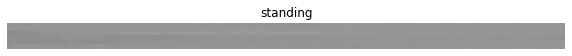

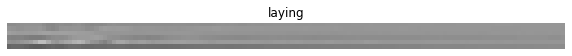

In [47]:
# Inspect some of the data by making plots

def make_plots(num_examples_per_category):
    for label in range(6):
        x_label = x_train[y_train[:, 0] == label]
        for i in range(num_examples_per_category):
            fig, ax = plt.subplots(figsize=(10, 1))
            ax.imshow(x_label[100*i].T, cmap='Greys', vmin=-1, vmax=1)
            ax.axis('off')
            if i == 0:
                ax.set_title(label_to_activity[label])
            plt.show()
        
make_plots(1)

#### 1D deterministic convolutional neural network

In [52]:
# Create standard deterministic model with:
# - Conv1D
# - MaxPooling
# - Flatten
# - Dense with Softmax

model_deterministic = Sequential([
    Conv1D(input_shape=(128, 6), filters=8, kernel_size=16, activation='relu'),
    MaxPooling1D(pool_size=16),
    Flatten(),
    Dense(units=6, activation='softmax')
])
model_deterministic.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 113, 8)            776       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 7, 8)              0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 56)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 342       
Total params: 1,118
Trainable params: 1,118
Non-trainable params: 0
_________________________________________________________________


#### Probabilistic 1D convolutional neural network, with both weight and output uncertainty

In [53]:
# Create probablistic model with the following layers:
#  - Conv1D (epistemic uncertainty modelling)
#  - MaxPooling
#  - Flatten
#  - Dense (epistemic uncertainty modelling)
#  - OneHotCategorical (aleatoric uncertainty modelling) 

# for that, tfp know the analytical solution
divergence_fn = lambda q, p, _ : tfd.kl_divergence(q, p) / x_train.shape[0]  # make it unbiased
# the reparameterization layers allow other loss functions as well

model_probabilistic = Sequential([
    # probabilistic version of 1D convolution layer
    tfpl.Convolution1DReparameterization(
        input_shape=(128, 6),  # size of the sensor outputs
        filters=8, kernel_size=16, activation='relu',  # same as previously
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,  # has fixed parameters
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),  # so it doesn't collapse into a deterministic (singular) parameter with just a mean an no (0) variance
        kernel_divergence_fn=divergence_fn,
        bias_prior_fn=tfpl.default_multivariate_normal_fn,  # has fixed parameters
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),  # so it doesn't collapse into a deterministic (singular) parameter with just a mean an no (0) variance
        bias_divergence_fn=divergence_fn
    ),
    # MaxPooling and Flatten don't have parameters, thus no probabilistic versions
    MaxPooling1D(pool_size=16),
    Flatten(),
    # probabilistic version of Dense layer
    tfpl.DenseReparameterization(
        units=tfpl.OneHotCategorical.params_size(6),  # number of categories
        activation=None,  # same as previously
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,  # has fixed parameters
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),  # so it doesn't collapse into a deterministic (singular) parameter with just a mean an no (0) variance
        kernel_divergence_fn=divergence_fn,
        bias_prior_fn=tfpl.default_multivariate_normal_fn,  # has fixed parameters
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),  # so it doesn't collapse into a deterministic (singular) parameter with just a mean an no (0) variance
        bias_divergence_fn=divergence_fn
    ),
    # probabilistic version of one hot encoded classification
    tfpl.OneHotCategorical(6)
])

model_probabilistic.summary()
# has the double number of parameters than the deterministic one (mean and stddev for every weight)

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_reparameterization_5  (None, 113, 8)            1552      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 7, 8)              0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 56)                0         
_________________________________________________________________
dense_reparameterization_2 ( (None, 6)                 684       
_________________________________________________________________
one_hot_categorical_2 (OneHo multiple                  0         
Total params: 2,236
Trainable params: 2,236
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Replace analytical Kullback-Leibler divergence with approximated one
# (in case that tfp doesn't know the analytical solution for the chosen prior and posterior)

def kl_approx(q, p, q_tensor):
  # this equals to the Monte Carlo approximation of the KL divergence (just the mean of the integrand)
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

divergence_fn = lambda q, p, q_tensor : kl_approx(q, p, q_tensor) / x_train.shape[0]

In [54]:
# Compile the model using the negative loglikelihood

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model_probabilistic.compile(loss=nll,
              optimizer=RMSprop(learning_rate=0.005),
              metrics=['accuracy'],
              experimental_run_tf_function=False)  # has to do with eager exec

In [56]:
# Train the model

model_probabilistic.fit(x_train, y_train_oh, epochs=20, verbose=False)
model_probabilistic.evaluate(x_train, y_train_oh)
model_probabilistic.evaluate(x_test, y_test_oh)

93/93 [==============================] - 0s 2ms/step - loss: 1.0026 - accuracy: 0.6651


[1.002643346786499, 0.665083110332489]

#### Inspect model performance

In [60]:
# Define function to analyse model predictions versus true labels

def analyse_model_predictions(image_num):

    # Show the accelerometer data
    print('------------------------------')
    print('Accelerometer data:')
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(x_test[image_num].T, cmap='Greys', vmin=-1, vmax=1)
    ax.axis('off')
    plt.show()

    # Print the true activity
    print('------------------------------')
    print('True activity:', label_to_activity[y_test[image_num, 0]])
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities
    predicted_probabilities = np.empty(shape=(200, 6))
    for i in range(200):
        predicted_probabilities[i] = model_probabilistic(x_test[image_num][np.newaxis, ...]).mean().numpy()[0]
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(6)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(6)])
    # Make the plots
    fig, ax = plt.subplots(figsize=(9, 3))
    bar = ax.bar(np.arange(6), pct_97p5, color='red')
    bar[y_test[image_num, 0]].set_color('green')
    bar = ax.bar(np.arange(6), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],
                       rotation=45, horizontalalignment='right')
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

------------------------------
Accelerometer data:


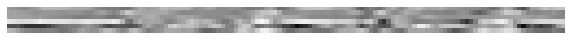

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:


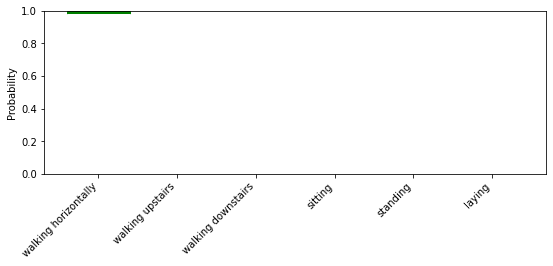

In [62]:
# call the analyze function with certain sample
analyse_model_predictions(image_num=79)

# here, this model is totally confident and also correct on the classification

------------------------------
Accelerometer data:


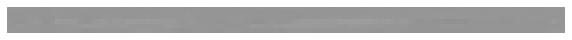

------------------------------
True activity: standing

------------------------------
Model estimated probabilities:


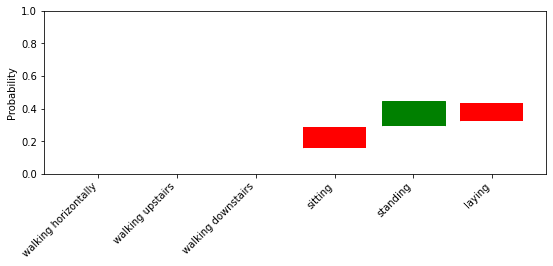

In [63]:
# call the analyze function with an uncertain sample
analyse_model_predictions(image_num=633)

# from the data it's hard to classify the activity (very little information)
# model is very uncertain about its classification 
# (assigns very different probabilities throughout the runs and also classifies different activities)

------------------------------
Accelerometer data:


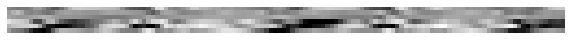

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:


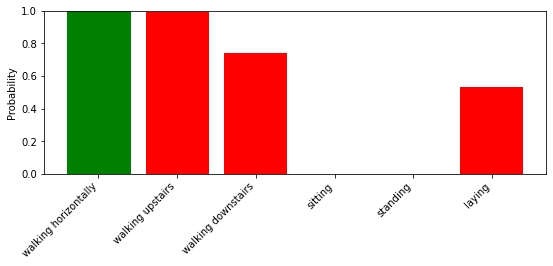

In [66]:
# call the analyze function with an very uncertain sample
analyse_model_predictions(image_num=1137)

# model is extreme uncertain about its classification 
# (from 0-100% probability for multiple actions)
# -> it knows what it doesn't know (needs more data on what it sees)